In [5]:
import pandas as pd
import html5lib
import os.path
import re
import string
import nltk
import json
import numpy as np
from pprint import pprint
from itertools import product
import math
from sklearn.cluster import KMeans
from nltk.stem.snowball import SnowballStemmer
pd.set_option('display.max_colwidth', 100)
pd.set_option('display.max_rows', 70)
pd.set_option('display.max_columns', 100)
from sklearn.metrics import confusion_matrix
import itertools
from sklearn import svm
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, cross_val_score, train_test_split, StratifiedKFold, StratifiedShuffleSplit
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import matplotlib.pyplot as plt
from scipy import stats
from time import time
import scipy
from sklearn.metrics import f1_score
from sklearn.base import BaseEstimator, TransformerMixin
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.pipeline import FeatureUnion, Pipeline
from tempfile import mkdtemp
from shutil import rmtree
import seaborn as sns
%matplotlib inline

In [6]:
#Create a dictionary to hold all values from file.
data = {}
#Create a dataframe to store all the edges.
df_edges = pd.DataFrame(columns = ['edgeID', 'fromID', 'toID'])
df_edges.set_index('edgeID')
#Create a dataframe to store all the nodes.
df_nodes = pd.DataFrame(columns = ['nodeID', 'text', 'type', "timestamp"])
df_nodes.set_index('nodeID')

#Cycle through all the nodeset JSON files in the same folder as this file.
for filename in os.listdir('.'):
    if filename.endswith('.json'):
        #For each file extract all the nodes and edges from the JSON.
        with open(os.path.join('.', filename)) as f:
            data = json.load(f)
            df_edges = df_edges.append(data['edges'], ignore_index=True)
            df_nodes = df_nodes.append(data['nodes'], ignore_index=True)

#Drop and rename columns for the nodes dataframe.
df_nodes = df_nodes.drop(columns = ['scheme', 'schemeID', 'timestamp'])
df_nodes = df_nodes.rename(columns={'nodeID': 'node_id'})
#Drop and rename columns for the edges dataframe.
df_edges = df_edges.drop(columns = ['formEdgeID', 'edgeID'])
df_edges = df_edges.rename(columns={'fromID': 'from_id', 'toID': 'to_id'})


In [7]:
#Adding the speaker to each I-node
#Create a dataframe with all I-nodes and their corresponding L-node.
#Create sub dataframe with all 'I' and 'L' nodes.
df_inodes = df_nodes[df_nodes['type'] == 'I']
df_lnodes = df_nodes[df_nodes['type'] == 'L']
#Create a datframe with all sets of three edges.
df_speaker = df_edges.merge(df_edges, left_on= 'to_id', right_on = 'from_id',
                              how='inner', validate = 'm:m')
#Rename columns after merging.
df_speaker = df_speaker.rename(columns = {'from_id_x': 'from_id',
                                          'to_id_x': 'transition_id',
                                          'to_id_y': 'to_id'})
#Drop extra columns after merging.
df_speaker = df_speaker.drop(columns = ['from_id_y'])
#Merge all the "from" nodes with the node dataframe.
df_speaker = df_speaker.merge(df_nodes, left_on=['from_id'],
                              right_on = ['node_id'], how='left')
#Rename the columns after the merge
df_speaker = df_speaker.rename(columns = {'text' : 'from_text',
                                          'type': 'from_type'})
#Merge all the transition nodes with nodes dataframe.
df_speaker = df_speaker.merge(df_nodes, left_on=['transition_id'],
                              right_on = ['node_id'], how='left')
#Rename the columns after the merge
df_speaker = df_speaker.rename(columns = {'text' : 'transition_text',
                                          'type': 'transition_type'})
#Merge the "to" nodes to the nodes dataframe.
df_speaker = df_speaker.merge(df_nodes, left_on=['to_id'],
                              right_on = ['node_id'], how='left')
#Rename columns after merging.
df_speaker = df_speaker.rename(columns = {'text' : 'to_text',
                                          'type': 'to_type'})
#Drop extra columns after merging.
df_speaker = df_speaker.drop(columns = ['node_id', 'node_id_y',
                                        'node_id_x'])
#Reindex columns needed after merging.
df_speaker = df_speaker.reindex(columns = ['from_id', 'transition_id', 'to_id',
                                           'from_text', 'transition_text',
                                           'to_text', 'from_type',
                                           'transition_type', 'to_type'])
#Filter the dataframe to I nodes on the right and L nodes on the left and 
# a YA node inbetween the two.
df_speaker = df_speaker[df_speaker['to_type'] == 'I']
df_speaker = df_speaker[df_speaker['from_type'] == 'L']
df_ilnodes = df_speaker
df_speaker = df_speaker[df_speaker['transition_type'] == 'YA']
#Use regex to extract the speaker from the L node.
speaker_regex = r'^((?:[0-9A-Z\'_]+ )*)'
df_speaker['speaker'] = df_speaker['from_text'].str.extract(speaker_regex,
                                                           expand = False)
#Drop all columns but node_id and speaker.
df_speaker = df_speaker[['to_id', 'speaker']]
#Drop any duplicated rows.
df_speaker.drop_duplicates(subset="to_id")
#Merge the speaker to the i_nodes dataframe
df_inodes = pd.merge(df_inodes, df_speaker, how='left', left_on='node_id',
                     right_on='to_id')
df_inodes = df_inodes.drop(columns=['to_id'])
df_inodes = df_inodes.drop_duplicates(subset=['node_id'])
df_inodes

/Users/alanmaceachen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,node_id,text,type,speaker
0,251800,Sounds like somebody's a little R-rated,I,KELLY
1,257046,The share of Americans who say race relations are bad in this country is the highest it's been i...,I,HOLT
2,257050,much of it amplified by shootings of African-Americans by police,I,HOLT
3,257057,we've seen recently in Charlotte and Tulsa,I,HOLT
4,257064,Race has been a big issue in this campaign,I,HOLT
5,257068,TRUMP is going to have to bridge a very wide and bitter gap,I,HOLT
6,257071,it is hard to heal the divide,I,HOLT
8,257082,Race remains a significant challenge in our country,I,CLINTON
9,257090,"Unfortunately, race still determines too much",I,CLINTON
10,257097,often determines where people live,I,CLINTON


In [8]:
#Create a dataframe with all sets of 3 nodes that have two I-nodes on
#either side and have an S-node inbetween. 
#Merge the edges with itself to create all copies of three sets of nodes.
df_arguments = df_edges.merge(df_edges, left_on= 'to_id', right_on = 'from_id',
                              how='inner', validate = 'm:m')
#Rename columns after merge.
df_arguments = df_arguments.rename(columns = {'from_id_x': 'from_id',
                                              'to_id_x': 'transition_id',
                                              'to_id_y': 'to_id'})
#Drop extra columns.
df_arguments = df_arguments.drop(columns = ['from_id_y'])
#Create a unique identifier for each set of three nodes.
df_arguments['argumentID'] = df_arguments['from_id'] +  df_arguments['to_id']
#Drop any duplicates columns.
df_arguments = df_arguments.drop_duplicates(subset='argumentID')
#Merge all the "from" nodes to the df_inodes with the text and speaker.
df_arguments = df_arguments.merge(df_inodes, left_on='from_id',
                                  right_on = 'node_id', how='left')
#Drop any rows that don't have and I-node as the left most node.
df_arguments = df_arguments.dropna(subset=["node_id"])
#Rename columns after merge.
df_arguments = df_arguments.rename(columns = {'text': 'from_text',
                                              'type': 'from_type',
                                              'speaker': 'from_speaker'})
#Drop any duplicates columns.
df_arguments = df_arguments.drop(columns = ['node_id'])
#Merge all the 'transition nodes to the df_nodes which contains the text.
df_arguments = df_arguments.merge(df_nodes, left_on='transition_id',
                                  right_on = 'node_id', how='left')
#Rename columns after merge.
df_arguments = df_arguments.rename(columns = {'text' : 'transition_text',
                                              'type': 'transition_type',
                                              'to_id_x': 'to_id'})
#Drop any duplicates columns.

df_arguments = df_arguments.drop(columns = ['node_id'])
#Merge all the "to" nodes to the df_inodes with the text and speaker.
df_arguments = df_arguments.merge(df_inodes, left_on='to_id',
                                  right_on = 'node_id', how='left')
#Rename columns after merge.
df_arguments = df_arguments.rename(columns = {'text' : 'to_text',
                                              'type': 'to_type',
                                              'speaker' : 'to_speaker',
                                             'to_id_x': 'to_id'})
#Drop any rows that don't have and I-node as the left most node.

df_arguments = df_arguments.dropna(subset=["node_id"])
df_arguments = df_arguments.drop(columns = ['node_id'])
#Reindex the final dataframe.
df_arguments = df_arguments.reindex(columns = ['argumentID','from_id',
                                               'transition_id', 'to_id',
                                               'from_text', 'transition_text',
                                               'to_text', 'from_type',
                                               'transition_type', 'to_type',
                                               'from_speaker', 'to_speaker'])
#Drop and duplicates that exist after merging.
df_arguments = df_arguments.drop_duplicates(subset='argumentID')
df_arguments

,argumentID,from_id,transition_id,to_id,from_text,transition_text,to_text,from_type,transition_type,to_type,from_speaker,to_speaker
0,257050257046,257050,257053,257046,much of it amplified by shootings of African-Americans by police,Default Inference,The share of Americans who say race relations are bad in this country is the highest it's been i...,I,RA,I,HOLT,HOLT
1,257057257050,257057,257060,257050,we've seen recently in Charlotte and Tulsa,Default Inference,much of it amplified by shootings of African-Americans by police,I,RA,I,HOLT,HOLT
2,257068257071,257068,257073,257071,TRUMP is going to have to bridge a very wide and bitter gap,Default Inference,it is hard to heal the divide,I,RA,I,HOLT,HOLT
3,257064257071,257064,257073,257071,Race has been a big issue in this campaign,Default Inference,it is hard to heal the divide,I,RA,I,HOLT,HOLT
4,257046257071,257046,257073,257071,The share of Americans who say race relations are bad in this country is the highest it's been i...,Default Inference,it is hard to heal the divide,I,RA,I,HOLT,HOLT
5,257082257046,257082,257085,257046,Race remains a significant challenge in our country,Default Rephrase,The share of Americans who say race relations are bad in this country is the highest it's been i...,I,MA,I,CLINTON,HOLT
6,257090257082,257090,257093,257082,"Unfortunately, race still determines too much",Default Inference,Race remains a significant challenge in our country,I,RA,I,CLINTON,CLINTON
7,257097257090,257097,257100,257090,often determines where people live,Default Inference,"Unfortunately, race still determines too much",I,RA,I,CLINTON,CLINTON
8,257104257090,257104,257100,257090,"determines what kind of education in their public schools they can get,",Default Inference,"Unfortunately, race still determines too much",I,RA,I,CLINTON,CLINTON
9,257108257090,257108,257100,257090,it determines how they're treated in the criminal justice system,Default Inference,"Unfortunately, race still determines too much",I,RA,I,CLINTON,CLINTON


In [9]:
#The value counts for each argument.
df_arguments.transition_type.value_counts(dropna=False)

RA    1853
MA     323
CA     193
YA       8
Name: transition_type, dtype: int64

In [10]:
#Create a dataframe with all the supporting arguments

df_MA_nodes = df_arguments[df_arguments['transition_type'] == 'MA']
df_MA_nodes = df_MA_nodes.reindex(['argumentID', 'from_id', 'to_id',
                                             'from_text', 'to_text',
                                             'from_speaker', 'to_speaker'],
                                            axis = 1)
df_MA_nodes['label'] = 'MA'


df_RA_nodes = df_arguments[df_arguments['transition_type'] == 'RA']
df_RA_nodes = df_RA_nodes.reindex(['argumentID', 'from_id', 'to_id',
                                             'from_text', 'to_text',
                                             'from_speaker', 'to_speaker'],
                                            axis = 1)
df_RA_nodes['label'] = 'RA'


df_CA_nodes = df_arguments[df_arguments['transition_type'] == 'CA']
df_CA_nodes = df_CA_nodes.reindex(['argumentID', 'from_id', 'to_id',
                                             'from_text', 'to_text',
                                             'from_speaker', 'to_speaker'],
                                            axis = 1)
df_CA_nodes['label'] = 'CA'

In [11]:
df_X_features = pd.concat([df_MA_nodes, df_RA_nodes, df_CA_nodes])
data = df_X_features
data = data.reset_index(drop=True)
data = data.sample(frac=1).reset_index(drop=True)
data.label.value_counts()

RA    1853
MA     323
CA     193
Name: label, dtype: int64

In [12]:
df = pd.DataFrame(data['to_speaker'] == data['from_speaker'], columns=['same_speaker'])
df = df.applymap(lambda x: 1 if x == True else x)
df = df.applymap(lambda x: 0 if x == False else x)
df = df.fillna(0)
data['same_speaker'] = df
data

,argumentID,from_id,to_id,from_text,to_text,from_speaker,to_speaker,label,same_speaker
0,214917214908,214917,214908,people feel like a lot of our legislators got railroaded in a war fever and by polls,people remain angry about it,O'MALLEY,O'MALLEY,RA,1
1,218990219048,218990,219048,PAUL is the leading voice in America for not arming the allies of ISIS,we will stop them,PAUL,PAUL,RA,1
2,218829218816,218829,218816,more people don't agree with HUCKABEE,Millions of people in this country agree with HUCKABEE,WALLACE,WALLACE,CA,1
3,248275248287,248275,248287,"as we all know, we all saw it",Americans should not trust O'MALLEY with the country,COOPER,COOPER,RA,1
4,233493233504,233493,233504,coming back from that abyss has not been easy,the last thing we need to do is to go back to the policies that failed us in the first place,CLINTON,CLINTON,RA,1
5,235095235103,235095,235103,TRUMP would go against TRUMP_LAWYERS if CLINTON releases CLINTON's e-mails,it 's negotiable,TRUMP,HOLT,RA,0
6,223913223904,223913,223904,They 're going to many other countries,Our jobs are fleeing the country,TRUMP,TRUMP,RA,1
7,220639220626,220639,220626,Florida 's low income kids had the greatest gains inside the country,we had rising student achievement across the board,BUSH,BUSH,RA,1
8,240848240841,240848,240841,WEBB believes that he is where the Democratic Party traditionally has been,WEBB is not out of step with where the Democratic Party is now,WEBB,NaN,RA,0
9,233672233665,233672,233665,our country is losing so much in terms of energy,our energy policies are a disaster,TRUMP,TRUMP,RA,1


In [13]:
print(data[data.label == "Conflict"].same_speaker.value_counts())


print(data[data.label == "Not Conflict"].same_speaker.value_counts())





Series([], Name: same_speaker, dtype: int64)
Series([], Name: same_speaker, dtype: int64)


In [14]:
stemmer = SnowballStemmer('english')

def clean_text(text):
    text = "".join([word.lower() for word in text if word not in string.punctuation])
    tokens = re.split('\W+', text)
    text = [stemmer.stem(word) for word in tokens if not any(c.isdigit() for c in word)]
    return text

def l2_norm(a):
    return math.sqrt(np.dot(a, a))

def cosinesim(a, b):
    return np.dot(a, b) / (l2_norm(a) * l2_norm(b)) 


#Create a count vectorizer.
count_vect = CountVectorizer(ngram_range=[1,2],analyzer=clean_text, stop_words='english')
#Create a dataframe to store the vector for each node.
df_vector = pd.DataFrame()
#Create a dataframe to store the result of the cosine.
df_cosine_similarty = pd.DataFrame()
#Fit the count vectorizer to both the from and the to nodes.
countvectfit = count_vect.fit(data[['to_text','from_text']].apply(lambda x : '{} {}'.format(x[0],x[1]), axis=1))
#Transform the to_node into a vector.
df_vector['to_node'] = countvectfit.transform(data['to_text']).toarray().tolist()
#Transform the from_node into a vector.
df_vector['from_node'] = countvectfit.transform(data['from_text']).toarray().tolist()
#Calculate the cosine similarty between the two nodes.
data['similarity'] = df_vector[['to_node', 'from_node']].apply(lambda x : cosinesim(*x), axis=1)


In [15]:
#Create a new DataFrame
structural = pd.DataFrame()
#Count the length of from nodes minues spaces
data['from_body_len'] = data['from_text'].apply(lambda x: float(len(x) - x.count(" "))).astype(float)
#Count the length of to nodes minues spaces
data['to_body_len'] = data['to_text'].apply(lambda x: float(len(x)- x.count(" "))).astype(float)
#Calculate the absolute difference between the two
data['body_len_diff'] = abs(data.from_body_len - data.to_body_len).astype(float)


In [16]:
SIA = SentimentIntensityAnalyzer()
polarirty = pd.DataFrame()
polarirty = pd.DataFrame(data['from_text'].apply(lambda x: SIA.polarity_scores(x)).to_dict()).T
polarirty = polarirty.join(pd.DataFrame(data['to_text'].apply(lambda x: SIA.polarity_scores(x)).to_dict()).T, rsuffix='_to')
data['pol_diff'] = abs(polarirty['compound'] - polarirty['compound_to'])
data['pos_to'] = polarirty['pos_to']
data['pos'] = polarirty['pos']
data['neu'] = polarirty['neu']
data['neu_to'] = polarirty['neu_to']
data['neg'] = polarirty['neg']
data['neg_to'] = polarirty['neg_to']
data['compound'] = polarirty['compound']
data['compound_to'] = polarirty['compound_to']


data.describe()

,same_speaker,similarity,from_body_len,to_body_len,body_len_diff,pol_diff,pos_to,pos,neu,neu_to,neg,neg_to,compound,compound_to
count,2369.000000,2369.000000,2369.00000,2369.000000,2369.000000,2369.000000,2369.000000,2369.000000,2369.000000,2369.000000,2369.000000,2369.000000,2369.000000,2369.000000
mean,0.867877,0.229967,55.55382,55.514985,34.292951,0.340119,0.098979,0.092449,0.820806,0.816997,0.086324,0.083606,0.012658,0.036423
std,0.338696,0.214686,35.88623,37.937046,34.734932,0.322687,0.148126,0.144218,0.186085,0.189177,0.145850,0.141898,0.366979,0.361933
min,0.000000,0.000000,1.00000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.946800,-0.930000
25%,1.000000,0.077850,31.00000,30.000000,10.000000,0.024000,0.000000,0.000000,0.690000,0.685000,0.000000,0.000000,-0.144600,-0.051600
50%,1.000000,0.181902,47.00000,45.000000,23.000000,0.296000,0.000000,0.000000,0.846000,0.844000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.333333,71.00000,70.000000,48.000000,0.526700,0.179000,0.168000,1.000000,1.000000,0.153000,0.149000,0.251400,0.296000
max,1.000000,1.000000,304.00000,344.000000,269.000000,1.764400,1.000000,0.855000,1.000000,1.000000,1.000000,0.700000,0.912300,0.928700


In [17]:
def Common_Terms(df):
    sentance1_split = set(clean_text(df['from_text']))
    count = 0
    for word in set(clean_text(df['to_text'])):
        if word in sentance1_split:
            count = count + 1
    return count

data['Common_Terms'] = pd.Series(data.apply(Common_Terms, axis = 1))

# Transformers

In [18]:
#Class for extracting strucural features from a dataframe
class Structural(BaseEstimator, TransformerMixin):
    """Takes in dataFrame, extracts the lengths of the from and to node and the difference between the two"""
    
    def __init__(self):
        pass
    
    def transform(self, X,):
        self.structural = pd.DataFrame(self.scaler_from.transform(pd.DataFrame(X['from_body_len'])), columns = ['from_body_length'])
        self.structural['to_body_len'] = self.scaler_to.transform(pd.DataFrame(X['to_body_len']))
        self.structural['body_len_diff'] = self.scaler_diff.transform(pd.DataFrame(X['body_len_diff']))
        return self.structural
    
    def get_feature_names(self):
        return self.structural.columns.tolist()
    
    def fit(self, X, y=None):
        #Create a scaler based on training data
        self.scaler_from = preprocessing.StandardScaler().fit(pd.DataFrame(X['from_body_len']))
        self.scaler_diff = preprocessing.StandardScaler().fit(pd.DataFrame(X['body_len_diff']))
        self.scaler_to = preprocessing.StandardScaler().fit(pd.DataFrame(X['to_body_len']))
        return self
    

In [19]:
#Class to calculate the cosine similarty between two nodes                                                                             |
class CosineSimilarity(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        pass
           
    def transform(self, X):
        #Use the scaler from the fitting data to scale transformed data.
        self.df_cosine_similarty = pd.DataFrame(self.scaler_cos.transform(pd.DataFrame(X['similarity'])), columns=['similarity'])
        #Return the dataframe
        return self.df_cosine_similarty

    def get_feature_names(self):
        return self.df_cosine_similarty.columns.tolist()
    
    def fit(self, X, y=None):
        #Store a scaler based on the training data.
        self.scaler_cos = preprocessing.StandardScaler().fit(pd.DataFrame(X['similarity']))
        return self

In [20]:
class Polarity(BaseEstimator, TransformerMixin):
    """Takes in dataFrame, extracts length of the from node"""
    
    def __init__(self, scale = True):
        pass
    def transform(self, X,):
        self.polarirty= pd.DataFrame(self.scaler_diff.transform(pd.DataFrame(X['pol_diff'])), columns=['pol_diff'])
        #polarirty['compound_to'] = self.scaler_comp_to.transform(pd.DataFrame(X['compound_to']))
        #polarirty['compound'] = self.scaler_comp.transform(pd.DataFrame(X['compound']))
        #polarirty['pos_to'] = self.scaler_pos_to.transform(pd.DataFrame(X['pos_to']))
        #polarirty['pos'] = self.scaler_pos.transform(pd.DataFrame(X['pos']))
        #polarirty['neg_to'] = self.scaler_neg_to.transform(pd.DataFrame(X['neg_to']))
        #polarirty['neg'] = self.scaler_neg.transform(pd.DataFrame(X['neg']))
        #polarirty['neu_to'] = self.scaler_neu_to.transform(pd.DataFrame(X['neu_to']))
        #polarirty['neu'] = self.scaler_neu.transform(pd.DataFrame(X['neu']))
        return self.polarirty
    
    def get_feature_names(self):
        return self.polarirty.columns.tolist()
    
    def fit(self, X, y=None):
        self.scaler_diff = preprocessing.StandardScaler().fit(pd.DataFrame(X['pol_diff']))
        self.scaler_neu = preprocessing.StandardScaler().fit(pd.DataFrame(X['neu']))
        self.scaler_neu_to = preprocessing.StandardScaler().fit(pd.DataFrame(X['neu_to']))
        self.scaler_pos = preprocessing.StandardScaler().fit(pd.DataFrame(X['pos']))
        self.scaler_pos_to = preprocessing.StandardScaler().fit(pd.DataFrame(X['pos_to']))
        self.scaler_neg = preprocessing.StandardScaler().fit(pd.DataFrame(X['neg']))
        self.scaler_neg_to = preprocessing.StandardScaler().fit(pd.DataFrame(X['neg_to']))
        self.scaler_comp = preprocessing.StandardScaler().fit(pd.DataFrame(X['compound']))
        self.scaler_comp_to = preprocessing.StandardScaler().fit(pd.DataFrame(X['compound_to']))
        return self


In [21]:
class Tfidf(BaseEstimator, TransformerMixin):
    
    def __init__(self, lower = 1, upper = 2, maxdf = 40, mindf = 2, norm = 'l2', maxfeatures = 250):
        self.lower = lower
        self.upper = upper
        self.maxdf = maxdf
        self.norm = norm
        self.maxf = maxfeatures
        self.mindf = mindf
           
    def transform(self, X):
        cols_to = [col + '_to' for col in self.col]
        cols_from = [col + '_from' for col in self.col]
        tfidf1 = pd.DataFrame(self.tfidf_fit_to.transform(X['to_text']).toarray(), columns=cols_to)
        tfidf2 = pd.DataFrame(self.tfidf_fit_to.transform(X['from_text']).toarray(), columns=cols_from)
        self.tfresult = pd.concat([tfidf1, tfidf2], axis = 1)
        return self.tfresult

    def get_feature_names(self):
        return self.tfresult.columns.tolist()
    
    def fit(self, X, y=None):
        tfidf = TfidfVectorizer(ngram_range=[self.lower, self.upper], tokenizer=clean_text, max_df = self.maxdf, min_df = self.mindf, stop_words='english', norm = self.norm, max_features=self.maxf)
        df = pd.concat([X['to_text'], X['from_text']])
        self.tfidf_fit_to = tfidf.fit(df)
        self.col = tfidf.get_feature_names()
        return self

In [22]:
class Modal(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        pass
     

        
    def transform(self, X):
        modalcv = CountVectorizer()
        modalcv.fit(['can', 'could', 'may', 'might', 'must', 'will', 'would', 'should'])
        df = pd.concat([pd.DataFrame(modalcv.transform(X['to_text']).toarray().tolist()), pd.DataFrame(modalcv.transform(X['from_text']).toarray().tolist())], axis = 1)
        df.columns = ['can_to', 'could_to', 'may_to', 'might_to',
                      'must_to', 'will_to', 'would_to', 'should_to',
                      'can_from', 'could_from', 'may_from', 'might_from',
                      'must_from', 'will_from', 'would_from', 'should_from']
        
    
        df['can_to'] = preprocessing.binarize(pd.DataFrame(df['can_to']))
        df['could_to'] = preprocessing.binarize(pd.DataFrame(df['could_to']))
        df['may_to'] = preprocessing.binarize(pd.DataFrame(df['may_to']))
        df['might_to'] = preprocessing.binarize(pd.DataFrame(df['might_to']))
        df['must_to'] = preprocessing.binarize(pd.DataFrame(df['must_to']))
        df['will_to'] = preprocessing.binarize(pd.DataFrame(df['will_to']))
        df['would_to'] = preprocessing.binarize(pd.DataFrame(df['would_to']))
        df['should_to'] = preprocessing.binarize(pd.DataFrame(df['should_to']))
        df['can_from'] = preprocessing.binarize(pd.DataFrame(df['can_from']))
        df['could_from'] = preprocessing.binarize(pd.DataFrame(df['could_from']))
        df['may_from'] = preprocessing.binarize(pd.DataFrame(df['may_from']))
        df['might_from'] = preprocessing.binarize(pd.DataFrame(df['might_from']))
        df['must_from'] = preprocessing.binarize(pd.DataFrame(df['must_from']))
        df['will_from'] = preprocessing.binarize(pd.DataFrame(df['will_from']))
        df['would_from'] = preprocessing.binarize(pd.DataFrame(df['would_from']))
        df['should_from'] = preprocessing.binarize(pd.DataFrame(df['should_from']))
        df = df.drop(columns=['may_from', 'must_to'])

        return df
    
    def get_feature_names(self):
        return df.columns.tolist()
    
    def fit(self, X, y=None):
        return self  

In [23]:
class CommonTerms(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        pass
     
    def transform(self, X):
        self.df = self.scaler_common.transform(pd.DataFrame(X['Common_Terms']))
        self.df = pd.DataFrame(self.df, columns=['Common_Terms'])
        return self.df
    
    def get_feature_names(self):
        return self.df.columns.tolist()
    
    def fit(self, X, y=None):
        self.scaler_common = preprocessing.StandardScaler().fit(pd.DataFrame((X['Common_Terms'])))
        return self

ct = CommonTerms()
ct.fit_transform(data)
data  
    

,argumentID,from_id,to_id,from_text,to_text,from_speaker,to_speaker,label,same_speaker,similarity,from_body_len,to_body_len,body_len_diff,pol_diff,pos_to,pos,neu,neu_to,neg,neg_to,compound,compound_to,Common_Terms
0,214917214908,214917,214908,people feel like a lot of our legislators got railroaded in a war fever and by polls,people remain angry about it,O'MALLEY,O'MALLEY,RA,1,0.102598,68.0,24.0,44.0,0.1706,0.000,0.129,0.670,0.548,0.201,0.452,-0.3400,-0.5106,1
1,218990219048,218990,219048,PAUL is the leading voice in America for not arming the allies of ISIS,we will stop them,PAUL,PAUL,RA,1,0.000000,57.0,14.0,43.0,0.2960,0.000,0.000,1.000,0.577,0.000,0.423,0.0000,-0.2960,0
2,218829218816,218829,218816,more people don't agree with HUCKABEE,Millions of people in this country agree with HUCKABEE,WALLACE,WALLACE,CA,1,0.544331,32.0,46.0,14.0,0.6955,0.238,0.000,0.678,0.762,0.322,0.000,-0.3343,0.3612,4
3,248275248287,248275,248287,"as we all know, we all saw it",Americans should not trust O'MALLEY with the country,COOPER,COOPER,RA,1,0.000000,22.0,45.0,23.0,0.4023,0.000,0.000,1.000,0.722,0.000,0.278,0.0000,-0.4023,0
4,233493233504,233493,233504,coming back from that abyss has not been easy,the last thing we need to do is to go back to the policies that failed us in the first place,CLINTON,CLINTON,RA,1,0.116052,37.0,72.0,35.0,0.1694,0.000,0.000,0.769,0.858,0.231,0.142,-0.3412,-0.5106,2
5,235095235103,235095,235103,TRUMP would go against TRUMP_LAWYERS if CLINTON releases CLINTON's e-mails,it 's negotiable,TRUMP,HOLT,RA,0,0.000000,65.0,14.0,51.0,0.0000,0.000,0.000,1.000,1.000,0.000,0.000,0.0000,0.0000,0
6,223913223904,223913,223904,They 're going to many other countries,Our jobs are fleeing the country,TRUMP,TRUMP,RA,1,0.154303,32.0,27.0,5.0,0.0000,0.000,0.000,1.000,1.000,0.000,0.000,0.0000,0.0000,1
7,220639220626,220639,220626,Florida 's low income kids had the greatest gains inside the country,we had rising student achievement across the board,BUSH,BUSH,RA,1,0.283473,57.0,43.0,14.0,0.6705,0.000,0.373,0.508,1.000,0.119,0.000,0.6705,0.0000,2
8,240848240841,240848,240841,WEBB believes that he is where the Democratic Party traditionally has been,WEBB is not out of step with where the Democratic Party is now,WEBB,NaN,RA,0,0.521749,63.0,50.0,13.0,0.0000,0.184,0.197,0.803,0.816,0.000,0.000,0.4019,0.4019,6
9,233672233665,233672,233665,our country is losing so much in terms of energy,our energy policies are a disaster,TRUMP,TRUMP,RA,1,0.258199,39.0,29.0,10.0,0.3308,0.228,0.165,0.630,0.326,0.205,0.446,-0.1280,-0.4588,2


In [24]:
class SameSpeaker(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        pass
     

        
    def transform(self, X):
        self.df = pd.DataFrame(X['to_speaker'] == X['from_speaker'], columns=['same_speaker'])
        self.df = self.df.applymap(lambda x: 1 if x == True else x)
        self.df = self.df.applymap(lambda x: 0 if x == False else x)
        self.df = self.df.fillna(0)
        return self.df
    
    def get_feature_names(self):
        return self.df.columns.tolist()

    
    def fit(self, X, y=None):
        return self

In [25]:
class dataframer(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        pass
     

        
    def transform(self, X):
        rus = RandomUnderSampler()
        col_names = X.columns
        
        col_types = X.dtypes
        X1 = X.values.astype("U")
        X_res = rus.fit_sample(X1, X.label)
        return pd.DataFrame(X_res[0], columns=col_names)


    
    def fit(self, X, y=None):
        return self

In [26]:
class BumbleBee(BaseEstimator, TransformerMixin):
    
    def __init(self, X):
        pass
    
    def transform(self, X):
        df = X.copy()
        encoded_labels = df['label'].map(lambda x: 1 if x == 'Related' or x == 1 else 0)
        return pd.DataFrame(encoded_labels)
        
        
    def fit(self, X, y=None):
        return self
    


In [27]:
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))
stop_words.remove('can')
stop_words.remove('will')
stop_words.remove('should')
stop_words.remove('shouldn')
stop_words.remove("shouldn't")
stop_words.remove('wouldn')
stop_words.remove("wouldn't")
stop_words.remove('because')
stop_words.remove('couldn')
stop_words.remove("couldn't")
stop_words.remove("shan't")
stop_words.remove("shan")
stop_words.remove("should've")
stop_words.remove("was")
stop_words.remove("wasn't")
stop_words.remove("wasn")
stop_words.remove("weren")
stop_words.remove("were")
stop_words.remove("weren't")
stop_words.remove("does")
stop_words.remove("doesn")
stop_words.remove("doesn't")

stop_words

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 're',
 's',
 'same',
 'she',
 "she's",
 'so',
 'some',
 'such',
 't',
 'than'

In [28]:
def word_pairs(row):
    output = []
    for from_word in row.from_text:
        for to_word in row.to_text:
            if from_word not in stop_words and to_word not in stop_words:
                new_word = from_word + '' + to_word
                output.append(new_word)
    return output


#stop_words = set()
stop_words.add('clinton')
stop_words.add('chafe')
stop_words.add('cruz')
stop_words.add('sander')
stop_words.add('trump')
stop_words.add('webb')
stop_words.add('walker')
stop_words.add('bush')
stop_words.add('walker')
stop_words.add('christi')
stop_words.add('omalley')
stop_words.add('rubio')


class WordPair(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        pass
           
    def transform(self, X):
        cleaned_text = pd.DataFrame(X['from_text'].apply(clean_text), columns=['from_text'])
        cleaned_text['to_text'] = X['to_text'].apply(clean_text)
        df_word_pairs = pd.DataFrame(cleaned_text.apply(word_pairs, axis=1), columns=['word_pairs'])
        df_word_pairs = pd.DataFrame(df_word_pairs['word_pairs'].apply(lambda x: ' '.join(x)), columns=['word_pairs'])
        self.df = pd.DataFrame(self.word_pairs_fit.transform(df_word_pairs['word_pairs']).toarray(),columns = self.cols)
        return self.df
    
    
    def get_feature_names(self):
        return self.df.columns.tolist()
    
    
    def fit(self, X, y=None):
        cv = TfidfVectorizer(min_df=3, norm='l2', max_features = 500)
        cleaned_text = pd.DataFrame(X['from_text'].apply(clean_text), columns=['from_text'])
        cleaned_text['to_text'] = X['to_text'].apply(clean_text)
        df_word_pairs = pd.DataFrame(cleaned_text.apply(word_pairs, axis=1), columns=['word_pairs'])
        df_word_pairs = pd.DataFrame(df_word_pairs['word_pairs'].apply(lambda x: ' '.join(x)), columns=['word_pairs'])
        self.word_pairs_fit = cv.fit(df_word_pairs['word_pairs'])
        self.cols = cv.get_feature_names()
        return self

In [29]:
wp  = WordPair()
train = data.sample(frac=0.8)
test = data.sample(frac=0.2)
wp.fit(train)
print(wp.transform(train).shape)
print(wp.transform(test).shape)


(1895, 500)
(474, 500)


In [30]:
class AllTransformers(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        pass
     

        
    def transform(self, X):

        return pd.concat([self.speaker.transform(X),
                          self.cosine.transform(X),
                          self.pol.transform(X),
                          #self.modal.fit_transform(X),
                            
                          self.common.transform(X),
                          self.stru.transform(X),
                          self.tfidf.transform(X),
                          self.wordpairs.transform(X),
                          self.bumble.transform(X)
                         ], axis = 1)
    
    def fit(self, X, y=None):
        self.cosine = CosineSimilarity().fit(X)
        self.stru = Structural().fit(X)
        self.pol = Polarity().fit(X)
        self.speaker = SameSpeaker().fit(X)
        self.tfidf = Tfidf().fit(X)
        self.common = CommonTerms().fit(X)
        #self.modal = Modal().fit(X)
        self.wordpairs = WordPair().fit(X)
        self.bumble = BumbleBee().fit(X)
        return self  
    

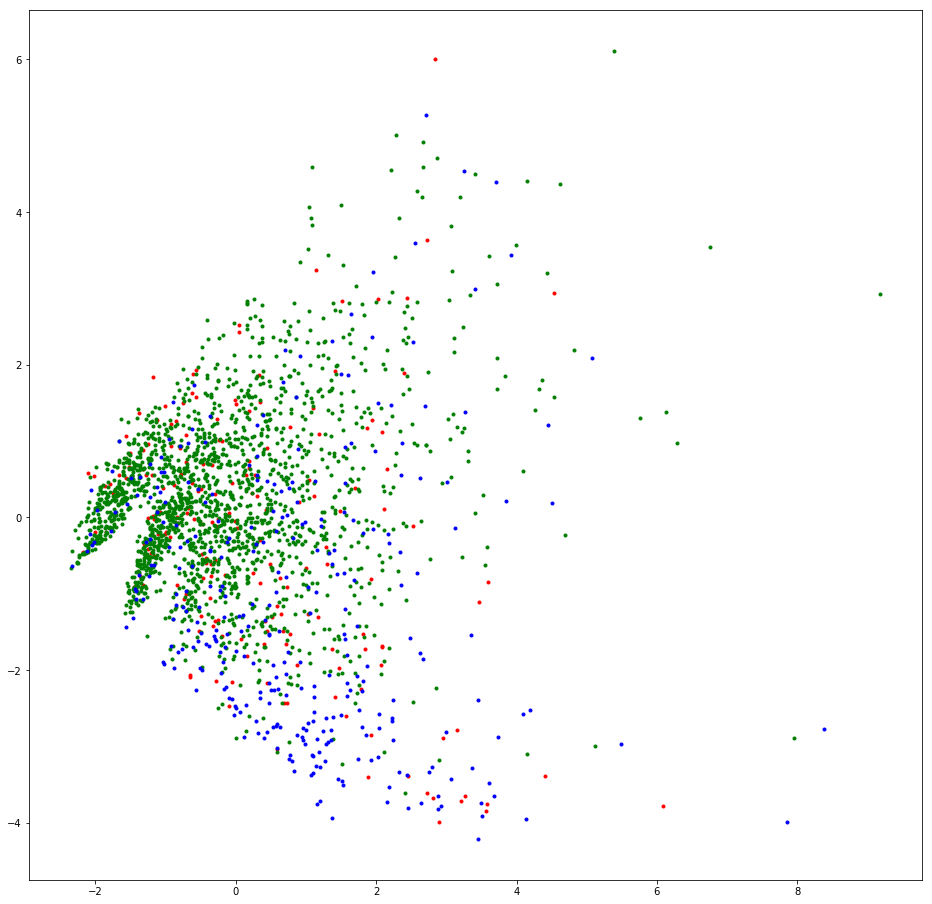

In [31]:
at = AllTransformers()
df_X_features = at.fit_transform(data)


import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
%matplotlib inline


X = df_X_features
y = data.label

pca = PCA(n_components=2)
pca.fit(X)
X_pca = pca.transform(X)
X_pca.shape



colors = ['red', 'green', 'blue']
plt.figure(figsize=(16,16))
for color, i, target_name in zip(colors, ['CA', 'RA', 'MA'], data.label):
        plt.scatter(X_pca[y==i, 0], X_pca[y==i,1],
                    color=color, label=target_name, marker='.')
        
plt.show()



In [32]:
data = data.sample(frac = 1)
encoded_labels = data['label'].map(lambda x: 1 if x == 'CA' else x)
from sklearn.linear_model import LogisticRegression
encoded_labels = encoded_labels.map(lambda x: 2 if x == 'RA' else x)
encoded_labels = encoded_labels.map(lambda x: 3 if x == 'MA' else x)


In [33]:
from sklearn.metrics import make_scorer
def CA_CA(y_true, y_pred): return confusion_matrix(y_true, y_pred)[0, 0]
def CA_RA(y_true, y_pred): return confusion_matrix(y_true, y_pred)[0, 1]
def CA_MA(y_true, y_pred): return confusion_matrix(y_true, y_pred)[0, 2]
def RA_CA(y_true, y_pred): return confusion_matrix(y_true, y_pred)[1, 0]
def RA_RA(y_true, y_pred): return confusion_matrix(y_true, y_pred)[1, 1]
def RA_MA(y_true, y_pred): return confusion_matrix(y_true, y_pred)[1, 2]
def MA_CA(y_true, y_pred): return confusion_matrix(y_true, y_pred)[2, 0]
def MA_RA(y_true, y_pred): return confusion_matrix(y_true, y_pred)[2, 1]
def MA_MA(y_true, y_pred): return confusion_matrix(y_true, y_pred)[2, 2]
scoring1 = {'CA_CA' : make_scorer(CA_CA), 'CA_RA' : make_scorer(CA_RA),
           'CA_MA' : make_scorer(CA_MA), 'RA_CA' : make_scorer(RA_CA),
            'RA_RA' : make_scorer(RA_RA), 'RA_MA' : make_scorer(RA_MA),
            'MA_CA' : make_scorer(MA_CA),'MA_RA' : make_scorer(MA_RA),
            'MA_MA' : make_scorer(MA_MA), 'f-score': 'f1_macro'}

In [59]:
start = time()
ppl = Pipeline([
    ('feats', FeatureUnion([
        ('cosine', CosineSimilarity()),
        ('speaker', SameSpeaker()),
        ('stru', Structural()),
        #('pol', Polarity()),
        ('common', CommonTerms()),
        ('tfid', Tfidf()),
        ('word', WordPair())
    ])),
    ('rand', RandomForestClassifier(class_weight='balanced'))
])

pg = {'rand__n_estimators': (50, 50, 50),
      'rand__max_depth': (None, None),
     }
grid = RandomizedSearchCV(ppl, pg,  cv=10, scoring=scoring1, n_iter=1,
                          return_train_score = False, verbose=100, refit = 'f-score')
grid_fit = grid.fit(data, encoded_labels)
print("Rando Grid Search took {:.2f} seconds".format(time()-start))

Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV] rand__n_estimators=50, rand__max_depth=None .....................
[CV]  rand__n_estimators=50, rand__max_depth=None, CA_CA=9, CA_RA=9, CA_MA=2, RA_CA=2, RA_RA=181, RA_MA=3, MA_CA=3, MA_RA=15, MA_MA=15, f-score=0.6737602342003249, total=  21.9s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   21.9s remaining:    0.0s
[CV] rand__n_estimators=50, rand__max_depth=None .....................
[CV]  rand__n_estimators=50, rand__max_depth=None, CA_CA=4, CA_RA=15, CA_MA=1, RA_CA=0, RA_RA=184, RA_MA=2, MA_CA=0, MA_RA=21, MA_MA=12, f-score=0.5799124247400109, total=  22.3s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   44.2s remaining:    0.0s
[CV] rand__n_estimators=50, rand__max_depth=None .....................
[CV]  rand__n_estimators=50, rand__max_depth=None, CA_CA=9, CA_RA=8, CA_MA=3, RA_CA=0, RA_RA=186, RA_MA=0, MA_CA=2, MA_RA=15, MA_MA=16, f-score=0.7126006428578907, total=  22.0s
[Parallel(n_jobs=1)]: Done   3 

In [60]:
pd.DataFrame(grid_fit.cv_results_)

,mean_fit_time,mean_score_time,mean_test_CA_CA,mean_test_CA_MA,mean_test_CA_RA,mean_test_MA_CA,mean_test_MA_MA,mean_test_MA_RA,mean_test_RA_CA,mean_test_RA_MA,mean_test_RA_RA,mean_test_f-score,param_rand__max_depth,param_rand__n_estimators,params,rank_test_CA_CA,rank_test_CA_MA,rank_test_CA_RA,rank_test_MA_CA,rank_test_MA_MA,rank_test_MA_RA,rank_test_RA_CA,rank_test_RA_MA,rank_test_RA_RA,rank_test_f-score,split0_test_CA_CA,split0_test_CA_MA,split0_test_CA_RA,split0_test_MA_CA,split0_test_MA_MA,split0_test_MA_RA,split0_test_RA_CA,split0_test_RA_MA,split0_test_RA_RA,split0_test_f-score,split1_test_CA_CA,split1_test_CA_MA,split1_test_CA_RA,split1_test_MA_CA,split1_test_MA_MA,split1_test_MA_RA,split1_test_RA_CA,split1_test_RA_MA,split1_test_RA_RA,split1_test_f-score,split2_test_CA_CA,split2_test_CA_MA,split2_test_CA_RA,split2_test_MA_CA,split2_test_MA_MA,...,split6_test_CA_RA,split6_test_MA_CA,split6_test_MA_MA,split6_test_MA_RA,split6_test_RA_CA,split6_test_RA_MA,split6_test_RA_RA,split6_test_f-score,split7_test_CA_CA,split7_test_CA_MA,split7_test_CA_RA,split7_test_MA_CA,split7_test_MA_MA,split7_test_MA_RA,split7_test_RA_CA,split7_test_RA_MA,split7_test_RA_RA,split7_test_f-score,split8_test_CA_CA,split8_test_CA_MA,split8_test_CA_RA,split8_test_MA_CA,split8_test_MA_MA,split8_test_MA_RA,split8_test_RA_CA,split8_test_RA_MA,split8_test_RA_RA,split8_test_f-score,split9_test_CA_CA,split9_test_CA_MA,split9_test_CA_RA,split9_test_MA_CA,split9_test_MA_MA,split9_test_MA_RA,split9_test_RA_CA,split9_test_RA_MA,split9_test_RA_RA,split9_test_f-score,std_fit_time,std_score_time,std_test_CA_CA,std_test_CA_MA,std_test_CA_RA,std_test_MA_CA,std_test_MA_MA,std_test_MA_RA,std_test_RA_CA,std_test_RA_MA,std_test_RA_RA,std_test_f-score
0,18.825295,3.733922,5.606585,2.19924,11.496834,1.102153,12.706205,18.494301,0.799493,2.098354,182.404812,0.609253,None,50,"{'rand__n_estimators': 50, 'rand__max_depth': None}",1,1,1,1,1,1,1,1,1,1,9.0,2.0,9.0,3.0,15.0,15.0,2.0,3.0,181.0,0.67376,4.0,1.0,15.0,0.0,12.0,21.0,0.0,2.0,184.0,0.579912,9.0,3.0,8.0,2.0,16.0,...,12.0,1.0,15.0,16.0,1.0,3.0,181.0,0.650487,6.0,3.0,10.0,1.0,14.0,17.0,1.0,4.0,180.0,0.630371,3.0,2.0,14.0,0.0,11.0,21.0,0.0,1.0,184.0,0.55396,6.0,1.0,12.0,2.0,9.0,21.0,0.0,1.0,184.0,0.592824,0.538696,0.108608,2.691648,0.871663,2.731415,1.045459,2.101028,2.46291,0.872099,1.136538,1.961511,0.064645


In [61]:
CA_CA = 0
CA_RA = 0
CA_MA = 0
RA_CA = 0
RA_RA = 0
RA_MA = 0
MA_CA = 0
MA_RA = 0
MA_MA = 0

for i in range(10):
    CA_CA += grid_fit.cv_results_['split' + str(i) + '_test_CA_CA'][0]
    CA_RA += grid_fit.cv_results_['split' + str(i) + '_test_CA_RA'][0]
    CA_MA += grid_fit.cv_results_['split' + str(i) + '_test_CA_MA'][0]
    RA_CA += grid_fit.cv_results_['split' + str(i) + '_test_RA_CA'][0]
    RA_RA += grid_fit.cv_results_['split' + str(i) + '_test_RA_RA'][0]
    RA_MA += grid_fit.cv_results_['split' + str(i) + '_test_RA_MA'][0]
    MA_CA += grid_fit.cv_results_['split' + str(i) + '_test_MA_CA'][0]
    MA_RA += grid_fit.cv_results_['split' + str(i) + '_test_MA_RA'][0]
    MA_MA += grid_fit.cv_results_['split' + str(i) + '_test_MA_MA'][0]

In [62]:
print("CA_CA", CA_CA)
print("CA_CA", CA_RA)
print("CA_MA", CA_MA)
print("RA_CA", RA_CA)
print("RA_RA", RA_RA)
print("RA_MA", RA_MA)
print("MA_CA", MA_CA)
print("MA_RA", MA_RA)
print("MA_MA", MA_MA)

"""accuracy = (test_tn+test_tp)/ (test_tn+test_tp+test_fn+test_fp)
precision = (test_tp)/ (test_tp+test_fp)
recall = (test_tp)/ (test_tp+test_fn)
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)
print('f1-score: ', ((2*precision*recall)/(precision+recall)))"""

CA_CA 56.0
CA_CA 115.0
CA_MA 22.0
RA_CA 8.0
RA_RA 1824.0
RA_MA 21.0
MA_CA 11.0
MA_RA 185.0
MA_MA 127.0


'accuracy = (test_tn+test_tp)/ (test_tn+test_tp+test_fn+test_fp)\nprecision = (test_tp)/ (test_tp+test_fp)\nrecall = (test_tp)/ (test_tp+test_fn)\nprint("Accuracy: ", accuracy)\nprint("Precision: ", precision)\nprint("Recall: ", recall)\nprint(\'f1-score: \', ((2*precision*recall)/(precision+recall)))'

In [63]:
print("CA")
ca_prec = (CA_CA)/(CA_CA+RA_CA+MA_CA)
ca_rec = (CA_CA)/(CA_CA+CA_RA+CA_MA)
ca_f1 = 2*ca_prec*ca_rec/(ca_prec+ca_rec)
print("Precision:", ca_prec)
print("Recall:",ca_rec )
print("F1:", ca_f1)
print()
print("RA")
ra_prec = (RA_RA)/(RA_RA+CA_RA+MA_RA)
ra_rec = (RA_RA)/(RA_RA+RA_CA+RA_MA)
ra_f1 = 2*ra_prec*ra_rec/(ra_prec+ra_rec)
print("Precision:", ra_prec)
print("Recall:",ra_rec )
print("F1:", ra_f1)
print()
print("MA")
ma_prec = (MA_MA)/(MA_MA+RA_MA+CA_MA)
ma_rec = (MA_MA)/(MA_MA+MA_RA+MA_CA)
ma_f1 = 2*ma_prec*ma_rec/(ma_prec+ma_rec)
print("Precision:", ma_prec)
print("Recall:",ma_rec )
print("F1:", ma_f1)

CA
Precision: 0.7466666666666667
Recall: 0.29015544041450775
F1: 0.417910447761194

RA
Precision: 0.8587570621468926
Recall: 0.9843497031840259
F1: 0.9172743273824491

MA
Precision: 0.7470588235294118
Recall: 0.3931888544891641
F1: 0.5152129817444219


In [64]:
cm = np.array([[CA_CA, CA_RA, CA_MA], [RA_CA, RA_RA, RA_MA],
               [MA_CA, MA_RA, MA_MA]
     ], dtype=int)
cm

array([[  56,  115,   22],
       [   8, 1824,   21],
       [  11,  185,  127]])

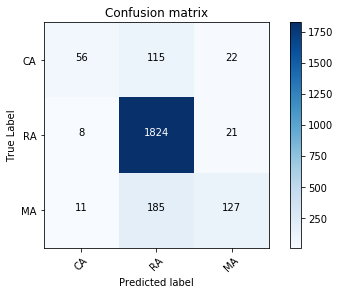

In [65]:
def plot_confusion_matrix(cm, classes,
                          title = 'Confusion matrix', 
    
                          cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt = 'd'
    thresh = cm.max()/2
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                horizontalalignment="center",
                color = "white" if cm[i, j] > thresh else "black")
    
    
    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted label')
    
    

plt.figure()
plot_confusion_matrix(cm, classes = ['CA', 'RA', 'MA'])

